In [ ]:
!pip install scanpy squidpy

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Interpret the results on mouse brain data

In [7]:
##Working with google colab
import torch
import os
import sys

os.chdir("/content/drive/MyDrive/Thesis/Projects/Steamboat_X/examples")
cwd = os.getcwd()
print(cwd)

sys.path.append("../")
if torch.cuda.is_available():
    device = "cuda"
    print("GPU: ",torch.cuda.get_device_name(0))
else:
    device = "cpu"
    print("Using CPU")

/content/drive/MyDrive/Thesis/Projects/Steamboat_X/examples
GPU:  Tesla T4


In [6]:
#Laptop
import os
import sys

sys.path.append("../")
if torch.cuda.is_available():
    device = "cuda"
    print(torch.cuda.get_device_name(0))
else:
    device = "cpu"
    print("Using CPU")


Tesla T4


In [8]:
import scanpy as sc
import squidpy as sq
import pandas as pd
from tqdm.notebook import tqdm
import scipy as sp
import numpy as np
import multiprocessing
import pickle as pkl
import torch
import gc
import sklearn.metrics

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

/usr/lib/python3.12/importlib/__init__.py:90: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)
/usr/local/lib/python3.12/dist-packages/squidpy/gr/_utils.py:23: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  CAN_USE_SPARSE_ARRAY = Version(anndata.__version__) >= Version("0.11.0rc1")
/usr/local/lib/python3.12/dist-packages/anndata/__init__.py:70: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)


In [9]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['font.family'] = 'DejaVu Sans'

pltkw = dict(bbox_inches='tight', transparent=True)

In [10]:
import steamboat as sf
import steamboat.tools
# importlib.reload(spaceformer.benchmarks)

## Astro-Epen in different regions

In [50]:
#adata_mmbrain = sc.read_h5ad("/content/drive/MyDrive/Thesis/Projects/Data/Steamboat_Data/saved_h5ad/mmbrain/mmbrain_0.h5ad")

In [11]:
saved_h5ad_path = "saved_h5ad"

In [12]:
# Load the annotated dataset by our model .
adata = sc.read_h5ad(f"{saved_h5ad_path}/Xmbrain_0_50_0.3.h5ad")

# Normalize and standardize gene expression values so that each gene
# has mean = 0 and variance = 1 (important for PCA and clustering).
sc.pp.scale(adata)

# Perform Principal Component Analysis (PCA) on the scaled data
# to reduce dimensionality and capture the main sources of variation.
sc.pp.pca(adata)

# Compute a k-nearest neighbors graph of cells in the PCA space.
sc.pp.neighbors(adata)

# Compute a UMAP (Uniform Manifold Approximation and Projection) embedding.
sc.tl.umap(adata)

/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


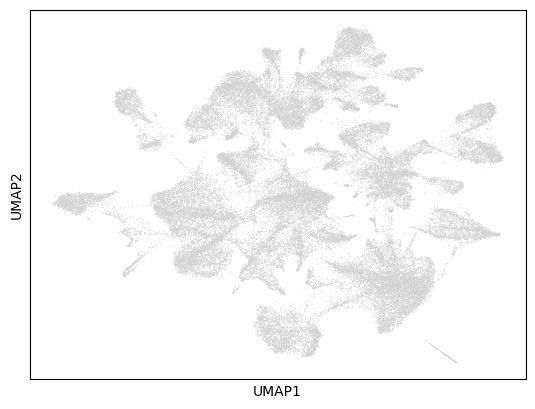

In [13]:
# Basic UMAP plot
sc.pl.umap(adata)

In [15]:
adatas = [sc.read_h5ad(f"{saved_h5ad_path}/Xmbrain_0_50_0.3.h5ad")]

## Head weights

In [16]:
model = sf.Steamboat(adata.var_names.tolist(), n_heads=50, n_scales=3)
model = model.to(device)


In [17]:
##working with google colab
model.load_state_dict(torch.load('saved_models/Xmbrain_new_50_0.3.pth', weights_only=True), strict=False)

<All keys matched successfully>

In [ ]:
##working with laptop
model.load_state_dict(torch.load('saved_models/Xmbrain_new.pth', map_location=torch.device('cpu'),weights_only=True))

<All keys matched successfully>

Using ['global'] as regional annotations.


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:04<00:00,  4.80s/it]


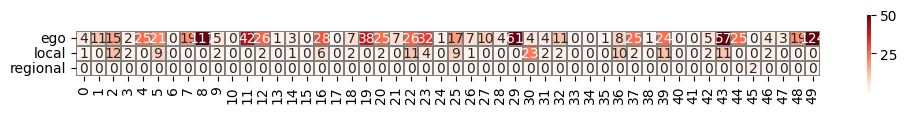

In [18]:
## For simplicity, we only visualize the weights from one slide here, not all of them.
dataset = sf.make_dataset(adatas, regional_obs=['global'])
sf.tools.calc_obs(adatas, dataset, model)
head_weights = sf.tools.calc_head_weights(device, adatas, model)
sf.tools.plot_head_weights(head_weights, figsize=(12, 1), multiplier=1000, heatmap_kwargs={'vmax': 50})

In [57]:
for key in adatas[0].obs.keys():
  print(f"{key} :", adatas[0].obs[f"{key}"].unique())

cell_id : ['aaaalabd-1' 'aaabcnhh-1' 'aaacnmip-1' ... 'oilgaepb-1' 'oilgmbbn-1'
 'oilhbhom-1']
transcript_counts : [2193 1873 2163 ...    4   20    8]
control_probe_counts : [1 0 2]
genomic_control_counts : [0 1 2]
control_codeword_counts : [0 1 2 3 4]
unassigned_codeword_counts : [ 3  0  1  4  2  6  5  7  8 12 10  9 13 11 14 16 15 20 17 19 18]
deprecated_codeword_counts : [2 0 1 3 4 5 8 6 7]
total_counts : [2199 1873 2165 ...   12   13    5]
cell_area : [ 49.62672055  55.22609575  85.79687811 ... 248.85610278 236.75422734
 209.84110137]
nucleus_area : [ 33.09953245  38.42797014  75.45609649 ... 140.4359426  133.34641109
 115.46453544]
nucleus_count : [1. 0. 2. 3.]
segmentation_method : ['Segmented by boundary stain (ATP1A1+CD45+E-Ca..., 'Segmented by interior stain (18S)', 'Segmented by nucleus expansion of 5.0µm']
Categories (3, object): ['Segmented by boundary stain (ATP1A1+CD45+E-Ca..., 'Segmented by interior stain (18S)',
                         'Segmented by nucleus expansion of

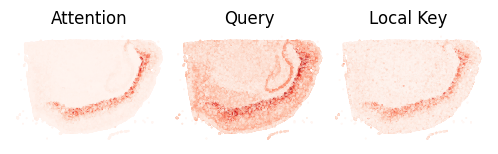

In [22]:
for i_head in range(2, 3): ## Change this to see more
    adatas[0].obs['a_obs'] = adatas[0].obsm['local_attn'][:, i_head]
    adatas[0].obs['q_obs'] = adatas[0].obsm['q'][:, i_head]
    adatas[0].obs['k_obs'] = adatas[0].obsm['local_k'][:, i_head]

    sq.pl.spatial_scatter(adatas[0],
                          color=['a_obs', 'q_obs', 'k_obs'],
                          shape=None, figsize=(2, 2), size=0.25,
                          legend_fontsize=9, cmap='Reds', ncols=3,
                          colorbar=False, vmin=0., wspace=.0,
                          outline=False, frameon=False,
                          title=['Attention', 'Query', 'Local Key']
                          )

## Clustering and spatial domain segmentaiton

In [ ]:
adata.obsm.keys()

KeysView(AxisArrays with keys: X_recon, attn, ego_attn, k_score, k_score_global, local_attn, q_score, regional_attn_0, spatial, X_pca, X_umap)

In [ ]:
!pip install igraph

In [ ]:
!pip install leidenalg

In [25]:
sf.tools.neighbors(adata, 'q_score')  #compute a neighborhood graph on attention embeddings
sf.tools.leiden(adata, resolution=1.)  #clustering cells using the Leiden algorithm

/content/drive/MyDrive/Thesis/Projects/Steamboat_X/examples/../steamboat/tools.py:410: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  return sc.tl.leiden(adata, obsp=obsp, key_added=key_added, resolution=resolution, **leiden_kwargs)


/usr/local/lib/python3.12/dist-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


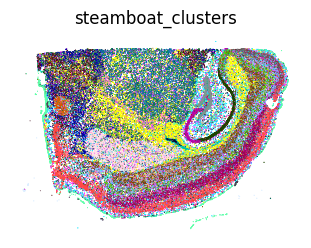

In [26]:
sq.pl.spatial_scatter(adata, color=['steamboat_clusters'], shape=None, figsize=(3, 3), ncols=2, legend_loc=None, frameon=False,
                                    size=2., lw=0.,
                      wspace=0.0, hspace=0.0)

In [ ]:
adata.uns.pop('steamboat_clusters_colors', None)

In [28]:
sf.tools.neighbors(adata, 'attn')  #compute a neighborhood graph on attention embeddings
sf.tools.leiden(adata, resolution=1.)  #clustering cells using the Leiden algorithm

/usr/local/lib/python3.12/dist-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


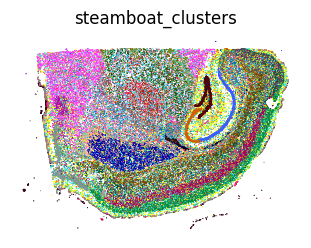

In [29]:
sq.pl.spatial_scatter(adata, color=['steamboat_clusters'], shape=None, figsize=(3, 3), ncols=2, legend_loc=None, frameon=False,
                                    size=2., lw=0.,
                      wspace=0.0, hspace=0.0)

/usr/local/lib/python3.12/dist-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


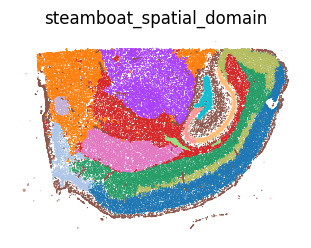

In [30]:
sf.tools.segment(adata, resolution=0.8)
sq.pl.spatial_scatter(adata, color=['steamboat_spatial_domain'], shape=None, figsize=(3, 3), ncols=2, legend_loc=None, frameon=False,
                                    size=2., lw=0.,
                      wspace=0.0, hspace=0.0)

## Ligand-receptor analysis

In [ ]:
import re

lrdb = pd.read_csv("E:/allen-brain-cell-atlas/aux_data/CellChatDB.mouse.csv", index_col=0)
lrdb

def parse_complex(s):
    if s[0] != '(':
        return [s]
    else:
        return s[1:-1].split('+')

def parse_lr(s):
    l, r = s.split(' - ')
    return parse_complex(l), parse_complex(r)

lrp = []
for i in lrdb['interaction_name_2']:
    ls, rs = parse_lr(i)
    for l in ls:
        for r in rs:
            lrp.append((l.strip(), r.strip()))

n_heads = 50

k_local = model.spatial_gather.k_local.weight.detach().cpu().numpy()
k_global = model.spatial_gather.k_regionals[0].weight.detach().cpu().numpy()
q = model.spatial_gather.q.weight.detach().cpu().numpy()
v = model.spatial_gather.v.weight.detach().cpu().numpy().T

adata = sc.read_h5ad(f"saved_h5ad/mmbrain_{0}.h5ad")

index = ([f'k_local_{i}' for i in range(n_heads)] +
         [f'k_global_{i}' for i in range(n_heads)] +
         [f'q_{i}' for i in range(n_heads)] +
         [f'v_{i}' for i in range(n_heads)])
gene_df = pd.DataFrame(np.vstack([k_local, k_global, q, v]),
                       index=index, columns=adata.var['gene_symbol']).T

normalized_gene_df = gene_df.multiply(adata.X.mean(axis=0), axis=0)
normalized_gene_df /= normalized_gene_df.max(axis=0)
lrp_dfs = []
for i in tqdm(range(n_heads)):
    lrp_df = pd.DataFrame(lrp, columns=['ligand', 'receptor'])
    lrp_df = lrp_df.drop_duplicates()
    lrp_df['lr'] = lrp_df['ligand'] + '-' + lrp_df['receptor']
    lrp_df = lrp_df[(lrp_df['ligand'].isin(adata.var['gene_symbol'].values)) & (lrp_df['receptor'].isin(adata.var['gene_symbol'].values))]

    lrp_df['kl_score'] = np.log(normalized_gene_df.loc[lrp_df['ligand'].tolist(), f'k_local_{i}'].tolist())
    lrp_df['qr_score'] = np.log(normalized_gene_df.loc[lrp_df['receptor'].tolist(), f'q_{i}'].tolist())
    lrp_df['lr_score'] = lrp_df['kl_score'] + lrp_df['qr_score']

    lrp_df['ql_score'] = np.log(normalized_gene_df.loc[lrp_df['ligand'].tolist(), f'q_{i}'].tolist())
    lrp_df['kr_score'] = np.log(normalized_gene_df.loc[lrp_df['receptor'].tolist(), f'k_local_{i}'].tolist())
    lrp_df['rl_score'] = lrp_df['kr_score'] + lrp_df['ql_score']

    lrp_df['k_to_q'] = lrp_df['lr_score'] > lrp_df['rl_score']

    lrp_df['score'] = np.maximum(lrp_df['lr_score'], lrp_df['rl_score'])

    xy = np.maximum((lrp_df['kl_score'].to_numpy() + lrp_df['qr_score'].to_numpy()[:, None]).flatten(),
                    (lrp_df['kr_score'].to_numpy() + lrp_df['ql_score'].to_numpy()[:, None]).flatten())
    lrp_df['p'] = (lrp_df['score'].to_numpy()[:, None] < xy).sum(axis=1) / len(xy)

    # xy = (lrp_df['kl_score'].to_numpy() + lrp_df['qr_score'].to_numpy()[:, None]).flatten(),
    # lrp_df['p_lr'] = (lrp_df['lr_score'].to_numpy()[:, None] < xy).sum(axis=1) / len(xy)

    # lrp_df['p_rl'] = float('nan')
    # xy = np.maximum((lrp_df['kl_score'].to_numpy() + lrp_df['qr_score'].to_numpy()[:, None]).flatten(),
    #                 (lrp_df['kr_score'].to_numpy() + lrp_df['ql_score'].to_numpy()[:, None]).flatten())

    # lrp_df['p'] = (lrp_df['lr_score'].to_numpy()[:, None] < xy).sum(axis=1) / len(xy)

    lrp_df['adj_p'] = sp.stats.false_discovery_control(lrp_df['p'])

    lrp_dfs.append(lrp_df.sort_values('p'))

lrp_dfs[5][lrp_dfs[5]['p'] < 0.05]

  0%|          | 0/50 [00:00<?, ?it/s]

,ligand,receptor,lr,kl_score,qr_score,lr_score,ql_score,kr_score,rl_score,k_to_q,score,p,adj_p
2579,Cldn11,Cldn11,Cldn11-Cldn11,-7.451209,-0.779319,-8.230528,-0.779319,-7.451209,-8.230528,False,-8.230528,0.000000,0.000000
444,Wnt4,Fzd5,Wnt4-Fzd5,-10.823726,-5.461134,-16.284859,-14.276980,-13.275460,-27.552441,True,-16.284859,0.039257,0.883598
919,Wnt5a,Fzd5,Wnt5a-Fzd5,-10.941229,-5.461134,-16.402363,-10.562279,-13.275460,-23.837739,True,-16.402363,0.040391,0.883598


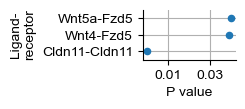

In [ ]:
fig, ax = plt.subplots(figsize=(1.2, 0.65))
lrp_dfs[5][lrp_dfs[5]['p'] < 0.05].plot.scatter(y='lr', x='p',  ax=ax)
ax.set_xticks([0.01, 0.03])
ax.set_ylabel('Ligand-\nreceptor')
ax.set_xlabel('P value')
for pos in ['right', 'top']:
    ax.spines[pos].set_visible(False)
ax.set_ylim([-0.5, 2.5])
ax.set_axisbelow(True)
ax.grid(axis='both', zorder=0)

C:\Users\lshh\AppData\Local\Temp\ipykernel_113232\3305993158.py:14: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f'{l}-{r}_colors'] = [color_map[i] for i in adata.obs[f'{l}-{r}'].cat.categories]


C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\squidpy\pl\_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
C:\Users\lshh\AppData\Local\Temp\ipykernel_113232\3305993158.py:14: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f'{l}-{r}_colors'] = [color_map[i] for i in adata.obs[f'{l}-{r}'].cat.categories]


C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\squidpy\pl\_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
C:\Users\lshh\AppData\Local\Temp\ipykernel_113232\3305993158.py:14: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f'{l}-{r}_colors'] = [color_map[i] for i in adata.obs[f'{l}-{r}'].cat.categories]


C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\squidpy\pl\_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


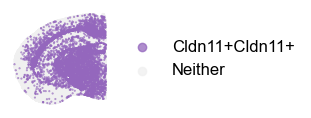

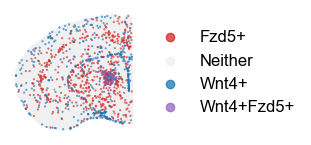

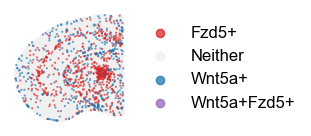

In [ ]:
def plot_lr(adata, l, r, l_cutoff=0, r_cutoff=0, figsize=(10, 10)):
    adata.obs[f'{l}-{r}'] = ''
    adata.obs.loc[(adata[:, l].X > l_cutoff).squeeze(), f'{l}-{r}'] += f'{l}+'
    adata.obs.loc[(adata[:, r].X > r_cutoff).squeeze(), f'{l}-{r}'] += f'{r}+'
    adata.obs.loc[adata.obs[f'{l}-{r}'] == '', f'{l}-{r}'] = 'Neither'
    adata.uns[f'{l}-{r}_colors'] = {'#f0f0f0', 'C0', 'C3', 'C4'}
    adata.obs[f'{l}-{r}'] = adata.obs[f'{l}-{r}'].astype('category')

    any = adata.obs_names[adata.obs[f'{l}-{r}'] != 'Neither'].tolist()
    neither = adata.obs_names[adata.obs[f'{l}-{r}'] == 'Neither'].tolist()

    adata = adata[neither + any, :]
    color_map = {'Neither': '#f0f0f0', f'{l}+': 'C0', f'{r}+': 'C3', f'{l}+{r}+': 'C4'}
    adata.uns[f'{l}-{r}_colors'] = [color_map[i] for i in adata.obs[f'{l}-{r}'].cat.categories]
    sq.pl.spatial_scatter(adata, color=[f'{l}-{r}'], shape=None, figsize=figsize, size=1.,
                          legend_fontsize=12, na_color='#f0f0f0', frameon=False, title='', alpha=.75, outline=False)

adata.var_names = adata.var['gene_symbol']

for i in lrp_dfs[5][lrp_dfs[5]['p'] < 0.05].index:
    plot_lr(adata, l=lrp_dfs[5].loc[i, 'ligand'], r=lrp_dfs[24].loc[i, 'receptor'], figsize=(3, 2), l_cutoff=.75, r_cutoff=.75)

## Interpretation of global attention
The global sample score of head 2 is correlated with the z-coordinate of slides.

In [ ]:
adata = sc.read_h5ad(f"{saved_h5ad_path}/mmbrain_{10}.h5ad")

In [ ]:
adata.uns['embk_0'][0, 2]

np.float32(0.3641144)

In [ ]:
adata.uns.keys()

dict_keys(['embk_0', 'log1p', 'spatial_neighbors'])

In [ ]:
# Global
glb = []
z = []
donor = []
for i in range(129):
    adata = sc.read_h5ad(f"{saved_h5ad_path}/mmbrain_{i}.h5ad")
    glb.append(adata.uns['embk_0'][0, 2])
    z.append(adata.obs['z'].unique().item())
    donor.append(adata.obs['donor_label'].astype(str).unique().item())

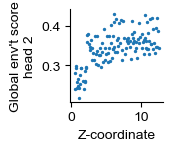

In [ ]:
fig, ax = plt.subplots(figsize=(1.2, 1.2))
plt.scatter(z, glb, s=2.)
for pos in ['right', 'top']:
    ax.spines[pos].set_visible(False)
ax.set_xlabel('Z-coordinate')
ax.set_ylabel("Global env't score\nhead 2")
# fig.savefig(savefig_path + f"zcoord.pdf", transparent=False, bbox_inches='tight')

In [ ]:
sp.stats.pearsonr(z, glb)

PearsonRResult(statistic=0.6239899360006265, pvalue=2.7930769923832913e-15)